# Batting Average Prediction

Batting average is among the most prevalent statistics to assess batters' performance, and as such its prediction is of great interest for managers and fans alike. The score captures how many hits a player can make out of his at-bat opportunities, and this notebook presents an example model to extrapolate the season batting average from only March-April statistics. 

## Dataset Overview

Let's first take a look at our dataset from the 2018 season!

In [1]:
using CSV, DataFrames

df = CSV.File("batting.csv") |> DataFrame

# First 5 rows
first(df, 5)

,playerid,Name,Team,MarApr_PA,MarApr_AB,MarApr_H,MarApr_HR
,Int64,String,String,Int64,Int64,Int64,Int64
1,11680,Elias Diaz,Pirates,34,31,15,2
2,12161,Xander Bogaerts,Red Sox,54,51,21,3
3,10816,Jedd Gyorko,Cardinals,30,22,8,2
4,13611,Mookie Betts,Red Sox,107,90,31,8
5,11493,Manny Machado,Orioles,125,108,39,9


At a glance, we have quite an ensemble of detailed statistics about our players. Fortunately, as the summary below demonstrates, there are no missing data and no apparent outliers.

In [2]:
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,playerid,9965.77,393,10346.0,19755,0,Int64
2,Name,,A.J. Pollock,,Zack Cozart,0,String
3,Team,,- - -,,Yankees,0,String
4,MarApr_PA,87.0259,30,91.0,137,0,Int64
5,MarApr_AB,77.0485,22,80.0,125,0,Int64
6,MarApr_H,19.4693,3,19.0,41,0,Int64
7,MarApr_HR,2.66667,0,2.0,10,0,Int64
8,MarApr_R,10.5922,1,10.0,29,0,Int64
9,MarApr_RBI,10.0388,0,9.0,30,0,Int64


There's a lot of data to learn from, but most of them are not really related to the batting average stat. Our criteria for a good model should include interpretability, so we might want to limit ourselves to variables whose influences we can explain, like number of hits and at-bat opportunities. One particular variable of interest is the batting average in March and April. Some might expect this would be a good estimate for the entire season, but as seen in the histogram plot below, the distribution while normal enough covers quite a wide range. With only a month into the season, the sample size (i.e. at-bats) for each player is still relatively small, resulting in much too large variance for it to be our point estimate for the 2018 season. 

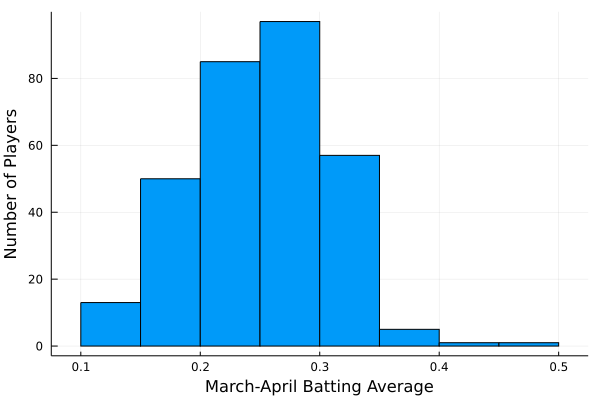

In [3]:
using StatsPlots

MarApr_AVG = df[:, :MarApr_AVG]

histogram(MarApr_AVG, xlabel="March-April Batting Average", ylabel="Number of Players", legend=:none)

At this stage, it's not obvious how we might proceed to generalize each player's performance. In real world use cases, a prediction model doesn't have access to end-of-season statistics just yet. Assuming there is an actual relationship between the first month performance with the entire season, a potential route is to fit our hypothetical model on 2017 data and hope that the model is general enough to work on 2018 data. A much more viable and self-contained alternative, however, is to directly encapsulate the uncertainties of March-April data through [Bayesian probabilistic modeling](https://en.wikipedia.org/wiki/Bayesian_inference). By perceiving a player's batting average as a probability distribution, we can reason about the variance of smaller samples and arrive at a reasonable estimate of what their expected batting average might be. Furthermore, working with a Bayesian approach means that our model can be adjusted as new statistics come along, i.e. if we provide new input in May, June, and so on. In the next section, we will examine a hierarchical Bayesian model to demonstrate this strategy in action.

## A Hierarchical Bayesian Model

Batting average lends itself naturally to a probabilistic interpretation: if each player has an objective latent ability to hit a ball with probability $p_i$, and his at-bat opportunities $N_i$ are assumed to be independent event, then his batting average must follow the distribution $Binomial(N_i, p_i)$. Starting with some prior guesstimates about $p_i$, we can then easily judge how likely it is to observe his actual batting average in March-April and update $p_i$ accordingly into a better posterior distribution.

If we have access to the players' past performances, we could use this information to model a prior. On the other hand, we might also be interested in whether we could extrapolate the season average from only the first month. A look back at our batting average histogram above offers a key insight in this regard: it seems the $p_i$'s are subject to a distribution across players as well! The shape suggests perhaps a normal distribution, but usually with binomial likelihood update we prefer a [beta prior distribution](https://en.wikipedia.org/wiki/Beta_distribution), which also covers a wide range of distribution shapes. The remaining difficulty is to figure out the $\alpha$ and $\beta$ parameters for our beta distribution.

Here, a possible empirical strategy would be to estimate $\alpha$ and $\beta$ from our dataset itself. Alternatively, instead of treating them as fixed points, we can push our Bayesian perspective even further and sample them as observations from yet another higher prior distribution. This hierarchy of hyper-priors can quickly escalate ad infinitum, but it's enough to impose an unassuming distribution at this stage since it will have access to our entire dataset to learn from. The common interpretations of $\alpha$ and $\beta$ are the number of successes and failures, respectively, which is quite arbitrary to decide on a good prior distribution. Instead, we will work with the mean and the variance of the beta distribution, which corresponds to the mean and the variance of our player's latent batting probabilities. $Uniform(0,1)$, for instance, is a very permissive prior for the universal batting average mean across players. For the variance, [it's recommended to use a weakly informative half-Cauchy prior to discourage the model from unrealistic variance](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf). Our batting average's variance during March-April is approximately $0.003$, but we'll loosen our prior variance assumption to a half-Cauchy distribution of median $0.01$. Half-Cauchy has a very smooth tail towards larger values, so we'll still be able to consider larger variance. From here, backtracking to $\alpha$ and $\beta$ is a simple task with the method of moments. By definition, a Beta distribution would have
$$
\mu = \frac{\alpha}{\alpha+\beta}\\
\sigma^2 = \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)} = \frac{\mu(1-\mu)}{\alpha+\beta+1}.
$$

With a bit of algebraic reformulation, we obtain:
$$
\alpha = \mu * \left[\frac{\mu(1-\mu)}{\sigma^2}-1\right]\\
\beta = (1-\mu) * \left[\frac{\mu(1-\mu)}{\sigma^2}-1\right],
$$
which gives us back our wanted parameters.

So for a comprehensive recap, our plan is to sample $\mu$ from a uniform distribution and $\sigma^2$ from a half-Cauchy one. We then use the method of moments to calculate the $\alpha$ and $\beta$ parameters for our Beta distribution. The latent batting probabilities will be sampled from this common distribution, and finally the actual batting averages serve as observations from the corresponding binomial distributions to update our entire hierarchy of priors. We could potentially work out our model's analytical Bayesian posteriors, but it's a lot easier to randomly sample from them to sketch out an approximation. To this end, we will be utilizing the [Turing.jl](https://turing.ml/stable/) probabilistic programming package, which will take care of the hard work for us. Our model is quite heavy on the theoretical side, but the software implementation below will hopefully show that it is actually quite straight-forward to implement in practice.

In [4]:
using Turing

###
### Half-Cauchy Distribution
###

# Unfortunately the half-Cauchy distribution isn't provided out of the box.
# But Turing is flexible enough to work with our own custom implementation!

# Define half-Cauchy as a subtype of ContinuousUnivariateDistribution
# This way, we only need to define a few specific methods from the interface,
# and Turing will take care of the rest. 
struct HalfCauchy <: ContinuousUnivariateDistribution
    γ::Float64 # median of the distribution
end

# We define logpdf instead of pdf for numerical stability reasons
function Distributions.logpdf(d::HalfCauchy, x::Real)
    γ = d.γ
    return -(log(γ) + Distributions.log1psq(x/γ) - log(2) + Distributions.logπ)
end

# Return the cdf at point `x`
function Distributions.cdf(d::HalfCauchy, x::Real)
    γ = d.γ
    return 2 * Distributions.invπ * atan(x,γ)
end

# Return the `p`-centile of our distribution
Distributions.quantile(d::HalfCauchy, p::Real) = d.γ * tan(p*π/2)

# Return the minimum of our distribution range
Distributions.minimum(d::HalfCauchy) = 0

# Return the maximum of our distribution range
Distributions.maximum(d::HalfCauchy) = Inf

# The `bijector` method maps our distribution range from [0, ∞) to (-∞, ∞)
# This allows Turing to automatically propagate our distribution density
# when we do computations on data sampled from half-Cauchy.
Bijectors.bijector(d::HalfCauchy) = Bijectors.Log{0}()

In [5]:
###
### Method of Moments
###

# Return the `α` and `β` parameters via method of moments
function moment_estimate(μ, σ²)
    sum = μ*(1-μ)/σ² - 1 # = α + β
    α = μ*sum
    β = (1-μ)*sum
    return α, β
end

moment_estimate (generic function with 1 method)

In [6]:
###
### Hierarchical Bayesian model
###

"""
Generate our hierarchical Bayesian model.

# Arguments
- `H`: a vector of number of hits by players
- `AB`: a vector of number of corresponding at-bat opportunities

The last argument is an optimization to allow Turing to generate type-stable code,
creating "static" code and reducing dynamic dispatch. 
"""
@model generate_model(H, AB, ::Type{T}=Float64) where {T} = begin
    N = length(H) # number of players

    # Hyper-hyper priors
    μ ~ Uniform(0, 1)
    σ² ~ truncated(HalfCauchy(0.01), 0, μ*(1-μ)) # truncated to make sure α and β > 0
    
    α, β = moment_estimate(μ, σ²)
    
    # Initialize latent probabilities
    P = Vector{T}(undef, N) # vector of type `T`, default to Float64
    for i in 1:N
        # Hyper-prior Beta
        P[i] ~ Beta(α, β)
        # Binomial prior for our observations
        H[i] ~ Binomial(AB[i], P[i])
    end
end

generate_model

In [7]:
###
### Posterior simulation
###

using Random
Random.seed!(1234) # For reproducibility

# Set automatic differentiation backend for Hamiltonian Monte Carlo sampling
Turing.setadbackend(:tracker)

H = df[:, :MarApr_H] # number of hits in March-April
AB = df[:, :MarApr_AB] # number of at-bat opportunities in March-April

batting_model = generate_model(H, AB)

# Sampling settings
sampler = HMC(0.01, 10) # Hamiltonian Monte Carlo sampler
iter = 1000 # number of sampling iterations

# Sample 3 different Monte Carlo chains and then concatenate them to test convergence
# This can easily be multi-threaded/distributed to simulate in parallel
chains = mapreduce(chain -> sample(batting_model, sampler, iter), chainscat, 1:3)

Sampling: 100%|█████████████████████████████████████████| Time: 0:01:59
Sampling: 100%|█████████████████████████████████████████| Time: 0:02:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:02:00


Chains MCMC chain (1000×320×3 Array{Float64, 3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 1000
parameters        = P[1], P[2], P[3], P[4], P[5], P[6], P[7], P[8], P[9], P[10], P[11], P[12], P[13], P[14], P[15], P[16], P[17], P[18], P[19], P[20], P[21], P[22], P[23], P[24], P[25], P[26], P[27], P[28], P[29], P[30], P[31], P[32], P[33], P[34], P[35], P[36], P[37], P[38], P[39], P[40], P[41], P[42], P[43], P[44], P[45], P[46], P[47], P[48], P[49], P[50], P[51], P[52], P[53], P[54], P[55], P[56], P[57], P[58], P[59], P[60], P[61], P[62], P[63], P[64], P[65], P[66], P[67], P[68], P[69], P[70], P[71], P[72], P[73], P[74], P[75], P[76], P[77], P[78], P[79], P[80], P[81], P[82], P[83], P[84], P[85], P[86], P[87], P[88], P[89], P[90], P[91], P[92], P[93], P[94], P[95], P[96], P[97], P[98], P[99], P[100], P[101], P[102], P[103], P[104], P[105], P[106], P[107], P[108], P[109], P[110], P[111], P[112], P[113], P[114], P[115], P[116], P[117],

That's a lot of information about our posterior distributions! Since we're only simulating what the distributions might look like via Monte Carlo chains, it's important to know whether our chains converge and our posterior approximations are appropriate. The plots below show that all of our chains coincide, and the distributions look good!

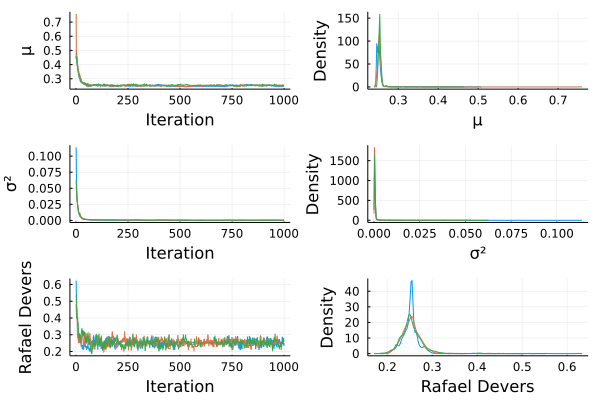

In [8]:
row = rand(1:length(H)) # select a random player

# Plots for μ
p1 = plot(chains[:μ], xlabel="Iteration", ylabel="μ")
p2 = plot(chains[:μ], seriestype=:density, xlabel="μ", ylabel="Density")

# Plots for σ²
p3 = plot(chains[:σ²], xlabel="Iteration", ylabel="σ²")
p4 = plot(chains[:σ²], seriestype=:density, xlabel="σ²", ylabel="Density")

# Plots for random player
name = df[row, :Name]
p5 = plot(chains[Symbol("P[$row]")], xlabel="Iteration", ylabel=name)
p6 = plot(chains[Symbol("P[$row]")], seriestype=:density, xlabel=name, ylabel="Density")

plot(p1, p2, p3, p4, p5, p6, layout=(3,2), legend=false)

## Model Prediction and Validation

Now that we've obtained the posterior distributions for each player's batting average, we simply take the distribution means as our point estimate. While this is the Bayesian estimate of their "true" batting abilities, we expect the batting average over the entire season would approximate about the same. To validate our result, we use root-mean-squared errors and compare the loss to two different baseline predictions. The first one is to use the actual March-April batting average, and the second one is to use the average of all players as the estimate for all of them.

In [11]:
# Root-mean-squared errors
rmse(ŷ, y) = sqrt(mean((ŷ .- y).^2)) # dot syntax is to vectorize computations

rmse (generic function with 1 method)

In [13]:
# Prediction
P = group(chains, :P) # get all batting average distributions
prediction = summarize(P, mean)[:, :mean] # use distributions means as predictions

# Actual
actual = df[:, :FullSeason_AVG]

@show rmse(MarApr_AVG, actual)
@show rmse(mean(MarApr_AVG), actual)
@show rmse(prediction, actual);

rmse(MarApr_AVG, actual) = 0.046755440297477725
rmse(mean(MarApr_AVG), actual) = 0.03149299038777817
rmse(prediction, actual) = 0.02796229189295503


Evidently we have significantly improved on the naive estimates. Compared to the March-April point estimates, our error is about halved, and we manage to beat the overall average predictor by a small margin. Note that unlike other types of predictor, we can still easily improve ours as data from more months come in. More experimentations in the future will tell us how much data we need before our prediction is sufficiently precise, perhaps around mid-season.